In [ ]:
# MASKED K MAP

In [1]:
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- Load eBOSS LRG catalog ---
catalog = "LRG"
region = "NGC"
with fits.open(f"data/eBOSS/eBOSS_{catalog}_clustering_data-{region}-vDR16.fits") as hd:
    data = hd[1].data

# --- Filter out invalid galaxies ---
data = data[data['Z'] > 0]
data = data[np.isfinite(data['RA']) & np.isfinite(data['DEC'])]

# --- Load and smooth Planck κ alm ---
alms = fits.open("data/COM_Lensing_4096_R3.00/MV/dat_klm.fits")[1].data
alm = alms['REAL'] + 1j * alms['IMAG']
lmax = hp.Alm.getlmax(len(alm))
nside = 2048

In [19]:
# Smooth κ map with 8' Gaussian beam
fwhm = 8
fwhm_rad = np.radians(fwhm / 60)
alm_smoothed = hp.smoothalm(alm, fwhm=fwhm_rad)
kappa_map = hp.alm2map(alm_smoothed, nside=nside, lmax=lmax)

# --- Load the mask map ---
mask = hp.read_map("data/COM_Lensing_4096_R3.00/mask.fits")

# --- Set stacking grid parameters ---
h = cosmo.h
box_size_hmpc = 100
box_size_mpc = box_size_hmpc * h
grid_size = 100
cell_size = box_size_mpc / grid_size
half_box = box_size_mpc / 2

offsets = np.linspace(-half_box + cell_size/2, half_box - cell_size/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x = off_x.ravel()
off_y = off_y.ravel()

stack_unmask = np.zeros((grid_size * grid_size,))
stack = np.zeros((grid_size * grid_size,))
count_unmask=np.zeros_like(stack_unmask)
count = np.zeros_like(stack)  # To count valid (unmasked) pixels

N = len(data)

In [12]:
#kappa_map.shape
mask[mask>0]

array([1., 1., 1., ..., 1., 1., 1.], shape=(33753894,), dtype='>f4')

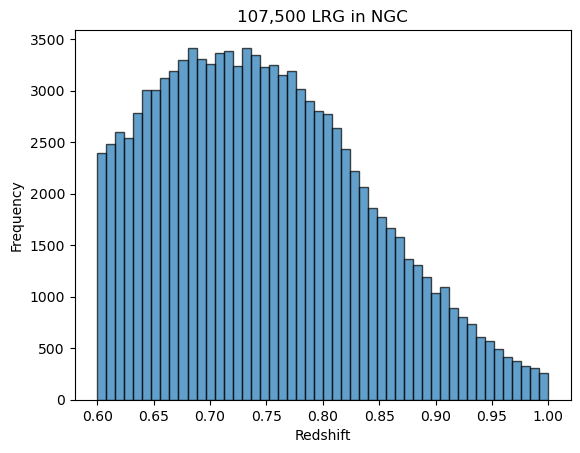

In [5]:
# --- Redshift histogram ---
zs = [gal['Z'] for gal in data]
plt.hist(zs, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title(f"{len(zs):,} {catalog} in {region}")
plt.show()

In [20]:
# --- Stacking loop ---
ic=0
for i in tqdm(range(N), desc=f'Stacking {catalog} {region}'):
    gal = data[i]
    ra, dec, z = gal['RA'], gal['DEC'], gal['Z']
    D = cosmo.comoving_distance(z).value  # in Mpc

    if D <= 0 or not np.isfinite(D):
        continue

    dRA_deg = (off_x / D / np.cos(np.radians(dec))) * (180 / np.pi)
    dDec_deg = (off_y / D) * (180 / np.pi)

    ra_grid = ra + dRA_deg
    dec_grid = dec + dDec_deg

    coords = SkyCoord(ra=ra_grid * u.deg, dec=dec_grid * u.deg, frame='icrs')
    gal_coords = coords.galactic
    theta = np.radians(90 - gal_coords.b.value)
    phi = np.radians(gal_coords.l.value)

    pixels = hp.ang2pix(nside, theta, phi)

    valid = mask[pixels] > 0
    if valid.sum() < len(mask[pixels]): 
        ic+=1 
    stack_unmask += kappa_map[pixels]
    stack[valid] += kappa_map[pixels[valid]]
    count_unmask += 1 
    count[valid] += 1

Stacking LRG NGC:   0%|          | 0/107500 [00:00<?, ?it/s]

In [38]:
kappa_stack_unmask

array([[ 1.01324794e-14,  7.30053213e-15,  1.76981069e-14, ...,
        -8.64754441e-14, -7.29477431e-14, -7.61229291e-14],
       [ 2.26971496e-14,  1.36123556e-14,  1.47328076e-14, ...,
        -8.07319020e-14, -7.68887418e-14, -7.33382473e-14],
       [ 1.59413645e-14,  1.54254460e-14,  9.22638659e-15, ...,
        -6.49571237e-14, -8.03158981e-14, -7.26370813e-14],
       ...,
       [-8.05932071e-14, -7.33505253e-14, -7.24392949e-14, ...,
        -2.81408026e-14, -2.54512276e-14, -2.82489585e-14],
       [-8.72466809e-14, -8.54947565e-14, -7.99034059e-14, ...,
        -2.50632708e-14, -2.94640247e-14, -2.20409451e-14],
       [-9.01087153e-14, -8.50638629e-14, -8.05030425e-14, ...,
        -4.20070139e-14, -3.35755307e-14, -2.95999708e-14]],
      shape=(100, 100))

In [39]:
kappa_stack

array([[ 1.13292775e-09,  8.16206037e-10,  1.97941526e-09, ...,
        -9.66143197e-09, -8.14619224e-09, -8.50367261e-09],
       [ 2.53833217e-09,  1.52222011e-09,  1.64760998e-09, ...,
        -9.01973718e-09, -8.58808117e-09, -8.19290729e-09],
       [ 1.78327373e-09,  1.72516782e-09,  1.03202733e-09, ...,
        -7.25882118e-09, -8.97257858e-09, -8.11334619e-09],
       ...,
       [-9.00902532e-09, -8.20407859e-09, -8.09970015e-09, ...,
        -3.14700283e-09, -2.84552405e-09, -3.15807912e-09],
       [-9.75407207e-09, -9.56002281e-09, -8.93310293e-09, ...,
        -2.80252151e-09, -3.29491702e-09, -2.46452473e-09],
       [-1.00706045e-08, -9.51111839e-09, -9.00048309e-09, ...,
        -4.69784784e-09, -3.75448675e-09, -3.31062221e-09]],
      shape=(100, 100))

In [35]:
# --- kappa map without Mask ---
stack_unmask = stack_unmask / N
kappa_stack_unmask = stack_unmask.reshape(grid_size, grid_size)

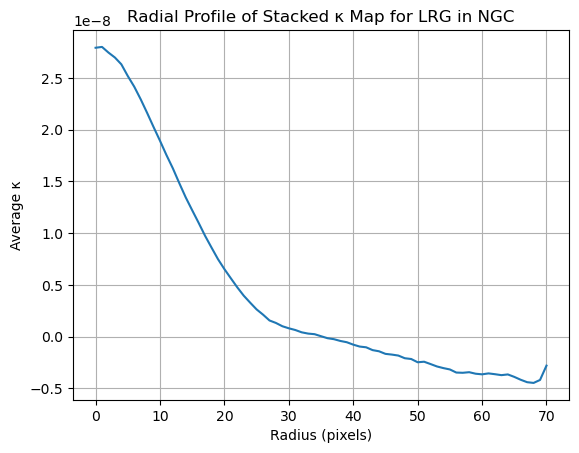

In [36]:
# --- Normalize by valid contributions only ---
valid_mask = count > 0
stack[valid_mask] /= count[valid_mask]

# --- Reshape ---
kappa_stack = stack.reshape(grid_size, grid_size)
count_map = count.reshape(grid_size, grid_size)

# --- Radial profile ---
y, x = np.indices(kappa_stack.shape)
center = (grid_size // 2, grid_size // 2)
r = np.sqrt((x - center[0])**2 + (y - center[1])**2).astype(int)

tbin = np.bincount(r.ravel(), kappa_stack.ravel())
nr = np.bincount(r.ravel())
radial_profile = tbin / nr

plt.plot(radial_profile)
plt.xlabel('Radius (pixels)')
plt.ylabel('Average κ')
plt.title(f'Radial Profile of Stacked κ Map for {catalog} in {region}')
plt.grid()
plt.show()

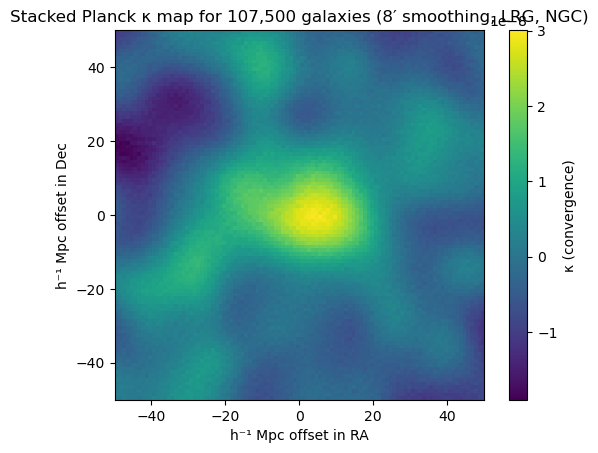

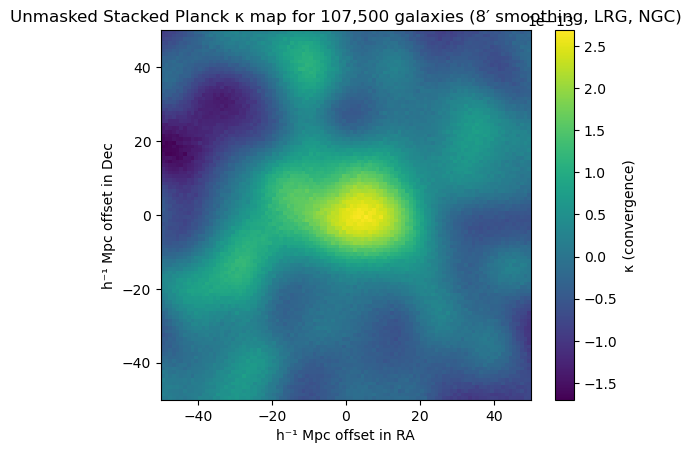

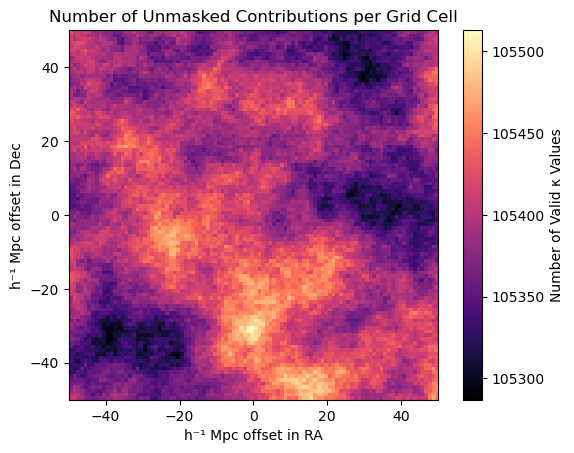

Min κ: -1.8994464565436034e-08
Max κ: 3.0085384895322816e-08
Min count: 105287.0
Max count: 105513.0


In [37]:
# --- Plot κ stack ---
#with mask
extent_hmpc = [-box_size_hmpc/2, box_size_hmpc/2, -box_size_hmpc/2, box_size_hmpc/2]
plt.imshow(kappa_stack, origin='lower', cmap='viridis', extent=extent_hmpc)
plt.colorbar(label='κ (convergence)')
plt.xlabel('h⁻¹ Mpc offset in RA')
plt.ylabel('h⁻¹ Mpc offset in Dec')
plt.title(rf"Stacked Planck κ map for {N:,} galaxies ({fwhm}′ smoothing, {catalog}, {region})")
plt.show()
#withOUT mask
plt.imshow(kappa_stack_unmask, origin='lower', cmap='viridis', extent=extent_hmpc)
plt.colorbar(label='κ (convergence)')
plt.xlabel('h⁻¹ Mpc offset in RA')
plt.ylabel('h⁻¹ Mpc offset in Dec')
plt.title(rf"Unmasked Stacked Planck κ map for {N:,} galaxies ({fwhm}′ smoothing, {catalog}, {region})")
plt.show()

# --- Optional: Plot number of valid contributions per grid cell ---
plt.imshow(count_map, origin='lower', cmap='magma', extent=extent_hmpc)
plt.colorbar(label='Number of Valid κ Values')
plt.xlabel('h⁻¹ Mpc offset in RA')
plt.ylabel('h⁻¹ Mpc offset in Dec')
plt.title('Number of Unmasked Contributions per Grid Cell')
plt.show()

# --- Diagnostics ---
print("Min κ:", np.min(kappa_stack))
print("Max κ:", np.max(kappa_stack))
print("Min count:", np.min(count_map))
print("Max count:", np.max(count_map))

In [ ]:
# MASKED + WEIGHTED K MAP

In [40]:
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- Load eBOSS LRG catalog ---
catalog = "LRG"
region = "NGC"
with fits.open(f"data/eBOSS/eBOSS_{catalog}_clustering_data-{region}-vDR16.fits") as hd:
    data = hd[1].data

print(data.columns.names)

# --- Filter out invalid galaxies ---
data = data[data['Z'] > 0]
data = data[np.isfinite(data['RA']) & np.isfinite(data['DEC'])]

# --- Load galaxy weights ---  # ← MODIFIED
weights = data['WEIGHT_NOZ'] * data['WEIGHT_SYSTOT']           # ← MODIFIED

# --- Load and smooth Planck κ alm ---
alms = fits.open("data/COM_Lensing_4096_R3.00/MV/dat_klm.fits")[1].data
alm = alms['REAL'] + 1j * alms['IMAG']
lmax = hp.Alm.getlmax(len(alm))
nside = 2048

['RA', 'DEC', 'Z', 'WEIGHT_FKP', 'WEIGHT_SYSTOT', 'WEIGHT_CP', 'WEIGHT_NOZ', 'NZ', 'LRG_ID']


In [41]:
# Smooth κ map with 8' Gaussian beam
fwhm = 8
fwhm_rad = np.radians(fwhm / 60)
alm_smoothed = hp.smoothalm(alm, fwhm=fwhm_rad)
kappa_map = hp.alm2map(alm_smoothed, nside=nside, lmax=lmax)

# --- Load the Planck mask ---  # ← MODIFIED
mask = hp.read_map("data/COM_Lensing_4096_R3.00/mask.fits")  # ← MODIFIED

# --- Set stacking grid parameters ---
h = cosmo.h
box_size_hmpc = 100
box_size_mpc = box_size_hmpc * h
grid_size = 100
cell_size = box_size_mpc / grid_size
half_box = box_size_mpc / 2

offsets = np.linspace(-half_box + cell_size/2, half_box - cell_size/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x = off_x.ravel()
off_y = off_y.ravel()

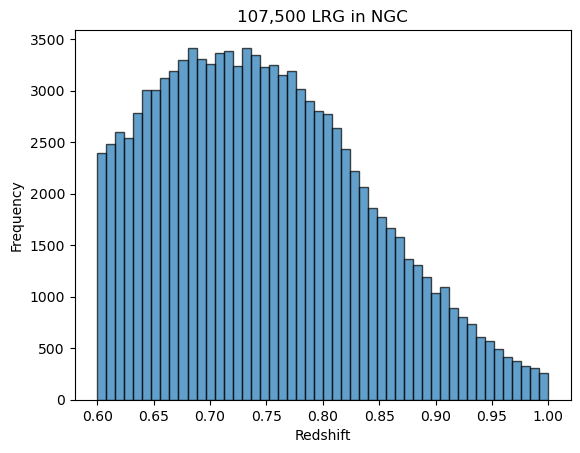

In [43]:
# --- Initialize stacking arrays ---
weighted_stack = np.zeros((grid_size * grid_size,))    # ← MODIFIED
weight_sum = np.zeros_like(weighted_stack)             # ← MODIFIED

N = len(data)

# --- Redshift histogram ---
zs = [gal['Z'] for gal in data]
plt.hist(zs, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title(f"{len(zs):,} {catalog} in {region}")
plt.show()

In [44]:
# --- Stacking loop ---
for i in tqdm(range(N), desc=f'Stacking {catalog} {region}'):
    gal = data[i]
    ra, dec, z = gal['RA'], gal['DEC'], gal['Z']
    D = cosmo.comoving_distance(z).value  # in Mpc

    if D <= 0 or not np.isfinite(D):
        continue

    dRA_deg = (off_x / D / np.cos(np.radians(dec))) * (180 / np.pi)
    dDec_deg = (off_y / D) * (180 / np.pi)

    ra_grid = ra + dRA_deg
    dec_grid = dec + dDec_deg

    coords = SkyCoord(ra=ra_grid * u.deg, dec=dec_grid * u.deg, frame='icrs')
    gal_coords = coords.galactic
    theta = np.radians(90 - gal_coords.b.value)
    phi = np.radians(gal_coords.l.value)

    pixels = hp.ang2pix(nside, theta, phi)

    w = weights[i]  # ← MODIFIED
    valid = mask[pixels] > 0  # ← MODIFIED

    weighted_stack[valid] += w * kappa_map[pixels[valid]]  # ← MODIFIED
    weight_sum[valid] += w  # ← MODIFIED

Stacking LRG NGC:   0%|          | 0/107500 [00:00<?, ?it/s]

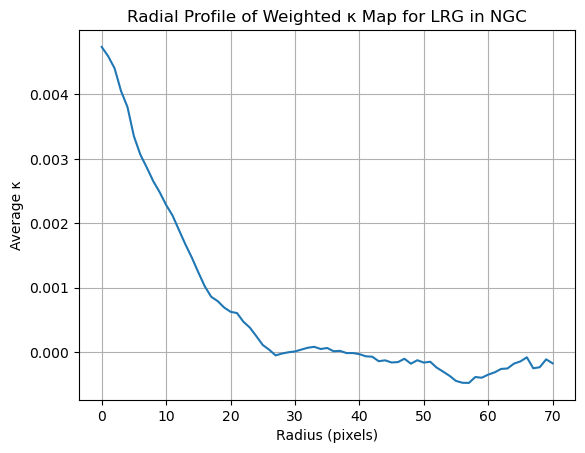

In [15]:
# --- Normalize using weighted average ---
valid_mask = weight_sum > 0  # ← MODIFIED
weighted_stack[valid_mask] /= weight_sum[valid_mask]  # ← MODIFIED

# --- Reshape to 2D map ---
kappa_stack = weighted_stack.reshape(grid_size, grid_size)  # ← MODIFIED
weight_map = weight_sum.reshape(grid_size, grid_size)       # ← MODIFIED

# --- Radial profile ---
y, x = np.indices(kappa_stack.shape)
center = (grid_size // 2, grid_size // 2)
r = np.sqrt((x - center[0])**2 + (y - center[1])**2).astype(int)

tbin = np.bincount(r.ravel(), kappa_stack.ravel())
nr = np.bincount(r.ravel())
radial_profile = tbin / nr

plt.plot(radial_profile)
plt.xlabel('Radius (pixels)')
plt.ylabel('Average κ')
plt.title(f'Radial Profile of Weighted κ Map for {catalog} in {region}')
plt.grid()
plt.show()

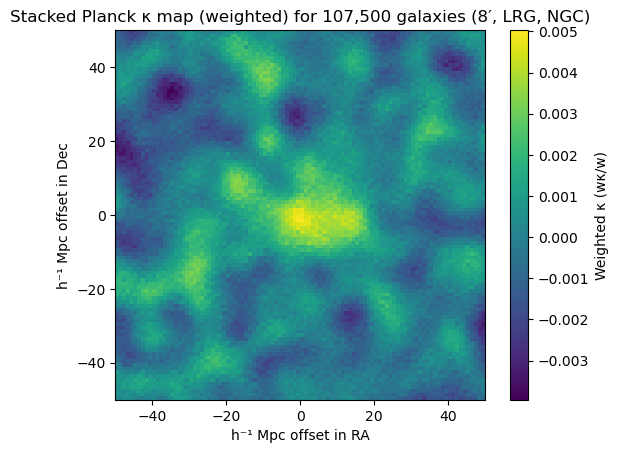

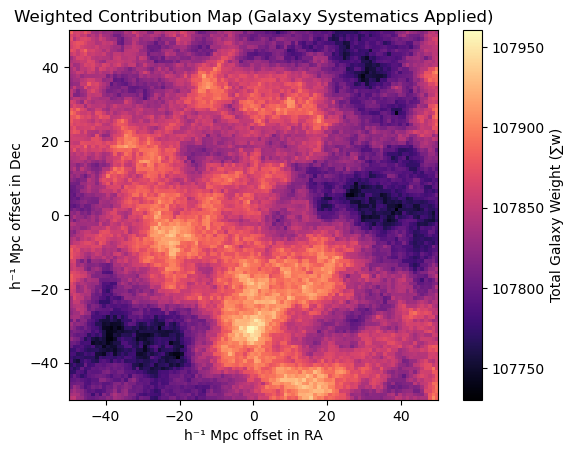

Min weighted κ: -0.003949903646563682
Max weighted κ: 0.005031317667255483
Min total weight per cell: 107730.3514352791
Max total weight per cell: 107960.6210560872


In [16]:
# --- Plot weighted κ stack ---
extent_hmpc = [-box_size_hmpc/2, box_size_hmpc/2, -box_size_hmpc/2, box_size_hmpc/2]
plt.imshow(kappa_stack, origin='lower', cmap='viridis', extent=extent_hmpc)
plt.colorbar(label='Weighted κ (wκ/w)')
plt.xlabel('h⁻¹ Mpc offset in RA')
plt.ylabel('h⁻¹ Mpc offset in Dec')
plt.title(rf"Stacked Planck κ map (weighted) for {N:,} galaxies ({fwhm}′, {catalog}, {region})")
plt.show()

# --- Optional: Plot weight sum per grid cell ---  # ← MODIFIED
plt.imshow(weight_map, origin='lower', cmap='magma', extent=extent_hmpc)
plt.colorbar(label='Total Galaxy Weight (∑w)')
plt.xlabel('h⁻¹ Mpc offset in RA')
plt.ylabel('h⁻¹ Mpc offset in Dec')
plt.title('Weighted Contribution Map (Galaxy Systematics Applied)')
plt.show()

# --- Diagnostics ---
print("Min weighted κ:", np.min(kappa_stack))
print("Max weighted κ:", np.max(kappa_stack))
print("Min total weight per cell:", np.min(weight_map))
print("Max total weight per cell:", np.max(weight_map))

In [ ]:
# MASKED, WEIGHTED, AND VARIANCE K MAP

In [18]:
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- Load LRG NGC catalog ---
catalog = "LRG"
region = "NGC"
with fits.open(f"data/eBOSS/eBOSS_{catalog}_clustering_data-{region}-vDR16.fits") as hd:
    data = hd[1].data

# --- Filter valid galaxies ---
data = data[data['Z'] > 0]
data = data[np.isfinite(data['RA']) & np.isfinite(data['DEC'])]

# --- Weights (NOZ × SYSTOT) ---
weights = data['WEIGHT_NOZ'] * data['WEIGHT_SYSTOT']  # ← weighted stacking

# --- Load and smooth Planck κ alm ---
alms = fits.open("data/COM_Lensing_4096_R3.00/MV/dat_klm.fits")[1].data
alm = alms['REAL'] + 1j * alms['IMAG']
lmax = hp.Alm.getlmax(len(alm))
nside = 2048

fwhm = 8
fwhm_rad = np.radians(fwhm / 60)
alm_smoothed = hp.smoothalm(alm, fwhm=fwhm_rad)
kappa_map = hp.alm2map(alm_smoothed, nside=nside, lmax=lmax)

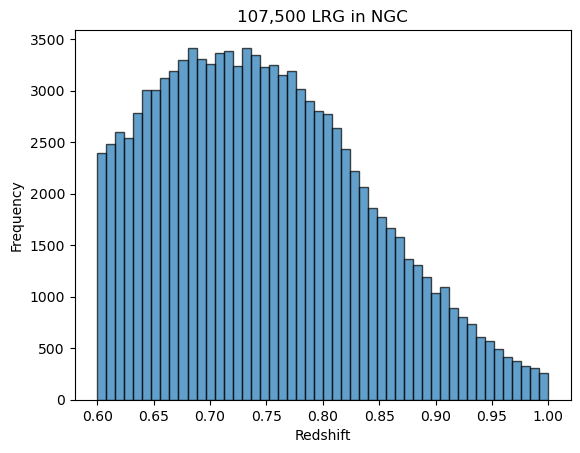

In [20]:
# --- Load mask ---
mask = hp.read_map("data/COM_Lensing_4096_R3.00/mask.fits")

# --- Grid setup ---
h = cosmo.h
box_size_hmpc = 100
box_size_mpc = box_size_hmpc * h
grid_size = 100
cell_size = box_size_mpc / grid_size
half_box = box_size_mpc / 2

offsets = np.linspace(-half_box + cell_size/2, half_box - cell_size/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x = off_x.ravel()
off_y = off_y.ravel()

# --- Initialize arrays ---
sum_wk = np.zeros((grid_size * grid_size,))
sum_w = np.zeros_like(sum_wk)
sum_wk2 = np.zeros_like(sum_wk)

# --- Redshift histogram ---
zs = [gal['Z'] for gal in data]
plt.hist(zs, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title(f"{len(zs):,} {catalog} in {region}")
plt.show()

In [21]:
# --- Stacking loop ---
for i in tqdm(range(len(data)), desc=f"Stacking {catalog} {region}"):
    gal = data[i]
    ra, dec, z = gal['RA'], gal['DEC'], gal['Z']
    D = cosmo.comoving_distance(z).value

    if D <= 0 or not np.isfinite(D):
        continue

    dRA_deg = (off_x / D / np.cos(np.radians(dec))) * (180 / np.pi)
    dDec_deg = (off_y / D) * (180 / np.pi)

    ra_grid = ra + dRA_deg
    dec_grid = dec + dDec_deg

    coords = SkyCoord(ra=ra_grid * u.deg, dec=dec_grid * u.deg, frame='icrs')
    gal_coords = coords.galactic
    theta = np.radians(90 - gal_coords.b.value)
    phi = np.radians(gal_coords.l.value)

    pixels = hp.ang2pix(nside, theta, phi)
    valid = mask[pixels] > 0
    w = weights[i]

    κ_vals = kappa_map[pixels[valid]]

    sum_wk[valid] += w * κ_vals
    sum_wk2[valid] += w * κ_vals**2
    sum_w[valid] += w

Stacking LRG NGC:   0%|          | 0/107500 [00:00<?, ?it/s]

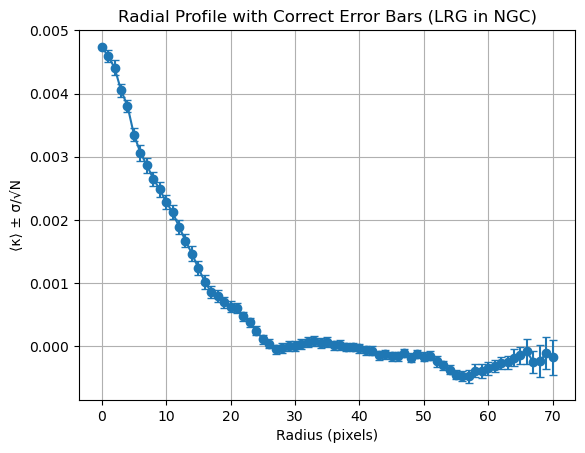

In [36]:
# --- Compute κ stats and S/N ---
valid_mask = sum_w > 0

kappa_mean = np.zeros_like(sum_w)
kappa_mean[valid_mask] = sum_wk[valid_mask] / sum_w[valid_mask]

kappa_var = np.zeros_like(sum_w)
kappa_var[valid_mask] = sum_wk2[valid_mask] / sum_w[valid_mask] - kappa_mean[valid_mask]**2

kappa_sigma = np.zeros_like(sum_w)
kappa_sigma[valid_mask] = np.sqrt(kappa_var[valid_mask])

# ✅ S/N computation (safe and in-place)
kappa_sn = np.zeros_like(sum_w)
nonzero_mask = (kappa_sigma > 0) & valid_mask
kappa_sn[nonzero_mask] = kappa_mean[nonzero_mask] / kappa_sigma[nonzero_mask]

kappa_stack = kappa_mean.reshape(grid_size, grid_size)
sigma_map = kappa_sigma.reshape(grid_size, grid_size)
sn_map = kappa_sn.reshape(grid_size, grid_size)

# --- Reshape to 2D maps ---
kappa_stack = kappa_mean.reshape(grid_size, grid_size)
sigma_map = kappa_sigma.reshape(grid_size, grid_size)
sn_map = kappa_sn.reshape(grid_size, grid_size)
weight_map = sum_w.reshape(grid_size, grid_size)

# --- Radial binning for profile + error bars ---
y, x = np.indices(kappa_stack.shape)
center = (grid_size // 2, grid_size // 2)
r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
r = r.astype(int)

kappa_flat = kappa_stack.ravel()
r_flat = r.ravel()

# Number of pixels per bin
nr = np.bincount(r_flat)

# Mean κ per bin
tbin = np.bincount(r_flat, weights=kappa_flat)
radial_profile = tbin / nr

# Variance per bin
kappa2_flat = kappa_flat ** 2
tbin2 = np.bincount(r_flat, weights=kappa2_flat)
mean_sq = tbin2 / nr
sq_mean = radial_profile ** 2
variance = mean_sq - sq_mean

# Standard error of the mean (σ / √N)
error = np.sqrt(variance / nr)

# --- Plot radial profile with proper error bars ---
plt.errorbar(np.arange(len(radial_profile)), radial_profile, yerr=error, fmt='o-', capsize=3)
plt.xlabel('Radius (pixels)')
plt.ylabel('⟨κ⟩ ± σ/√N')
plt.title(f"Radial Profile with Correct Error Bars ({catalog} in {region})")
plt.grid()
plt.show()

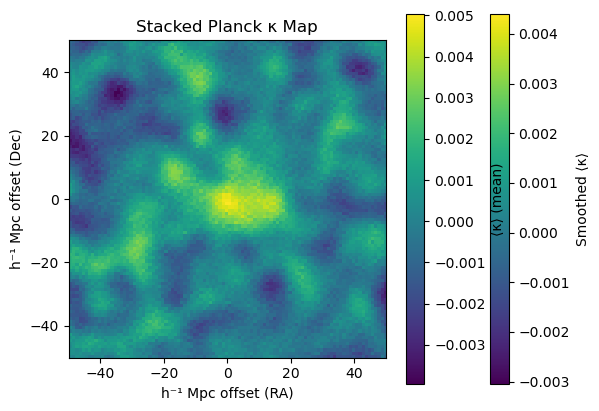

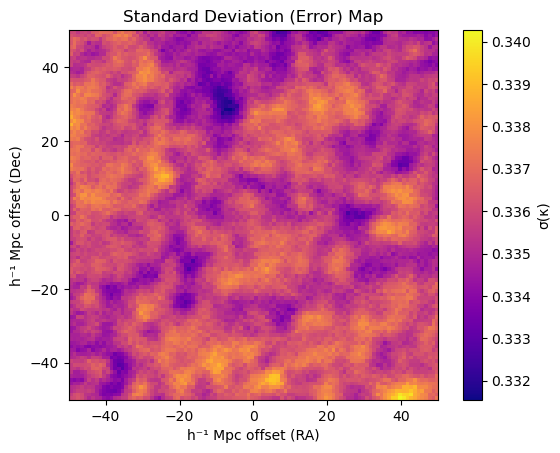

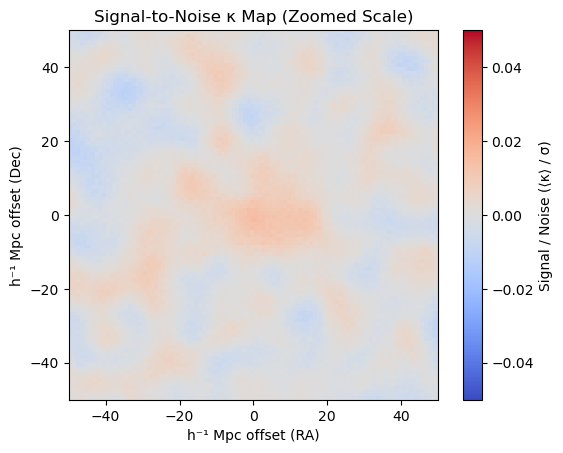

κ min: -0.003949903646563682
κ max: 0.005031317667255483
σ min: 0.3315522832567312
σ max: 0.3402705303676845
S/N min: -0.011730379722376777
S/N max: 0.014948814273306224


In [35]:
from scipy.ndimage import gaussian_filter
smoothed_kappa = gaussian_filter(kappa_stack, sigma=2)
plt.imshow(smoothed_kappa, origin='lower', cmap='viridis', extent=extent_hmpc)
plt.colorbar(label='Smoothed ⟨κ⟩')

# --- κ map ---
extent_hmpc = [-box_size_hmpc/2, box_size_hmpc/2, -box_size_hmpc/2, box_size_hmpc/2]
plt.imshow(kappa_stack, origin='lower', cmap='viridis', extent=extent_hmpc)
plt.colorbar(label='⟨κ⟩ (mean)')
plt.title("Stacked Planck κ Map")
plt.xlabel("h⁻¹ Mpc offset (RA)")
plt.ylabel("h⁻¹ Mpc offset (Dec)")
plt.show()

# --- σ map ---
plt.imshow(sigma_map, origin='lower', cmap='plasma', extent=extent_hmpc)
plt.colorbar(label='σ(κ)')
plt.title("Standard Deviation (Error) Map")
plt.xlabel("h⁻¹ Mpc offset (RA)")
plt.ylabel("h⁻¹ Mpc offset (Dec)")
plt.show()

# --- S/N map ---
plt.imshow(sn_map, origin='lower', cmap='coolwarm', extent=extent_hmpc, vmin=-0.05, vmax=0.05)
plt.colorbar(label='Signal / Noise (⟨κ⟩ / σ)')
plt.title("Signal-to-Noise κ Map (Zoomed Scale)")
plt.xlabel("h⁻¹ Mpc offset (RA)")
plt.ylabel("h⁻¹ Mpc offset (Dec)")
plt.show()

# --- Diagnostics ---
print("κ min:", np.min(kappa_stack))
print("κ max:", np.max(kappa_stack))
print("σ min:", np.min(sigma_map))
print("σ max:", np.max(sigma_map))
print("S/N min:", np.min(sn_map))
print("S/N max:", np.max(sn_map))

In [33]:
print("Max κ:", np.max(kappa_stack))
print("Max σ:", np.max(sigma_map))
print("Max S/N:", np.max(sn_map))
print("S/N range:", np.min(sn_map), "to", np.max(sn_map))

Max κ: 0.005031317667255483
Max σ: 0.3402705303676845
Max S/N: 0.014948814273306224
S/N range: -0.011730379722376777 to 0.014948814273306224


In [ ]:
# MASKED + WEIGHTED + VARIANCE + RANDOM K MAP

In [57]:
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- Parameters ---
catalog = "LRG"
region = "NGC"
random_catalog_file = random_catalog_file = f"data/eBOSS/eBOSS_{catalog}_clustering_random-{region}-vDR16.fits"

# --- Load data catalog ---
with fits.open(f"data/eBOSS/eBOSS_{catalog}_clustering_data-{region}-vDR16.fits") as hd:
    data = hd[1].data

In [58]:
# --- Load random catalog ---
with fits.open(random_catalog_file) as hd_rand:
    random_data = hd_rand[1].data

In [61]:
# --- Filter valid galaxies ---
data = data[data['Z'] > 0]
data = data[np.isfinite(data['RA']) & np.isfinite(data['DEC'])]
weights = data['WEIGHT_NOZ'] * data['WEIGHT_SYSTOT']

# --- Filter valid random points ---
random_data = random_data[random_data['Z'] > 0]
random_data = random_data[np.isfinite(random_data['RA']) & np.isfinite(random_data['DEC'])]
# Random catalogs typically do not have NOZ or SYSTOT weights, use uniform weights = 1
random_weights = np.ones(len(random_data))

# --- Load and smooth Planck κ alm ---
alms = fits.open("data/COM_Lensing_4096_R3.00/MV/dat_klm.fits")[1].data
alm = alms['REAL'] + 1j * alms['IMAG']
lmax = hp.Alm.getlmax(len(alm))
nside = 2048

fwhm = 8  # arcmin
fwhm_rad = np.radians(fwhm / 60)
alm_smoothed = hp.smoothalm(alm, fwhm=fwhm_rad)
kappa_map = hp.alm2map(alm_smoothed, nside=nside, lmax=lmax)

# --- Load mask ---
mask = hp.read_map("data/COM_Lensing_4096_R3.00/mask.fits")

In [65]:
# --- Grid setup ---
h = cosmo.h
box_size_hmpc = 100
box_size_mpc = box_size_hmpc * h
grid_size = 100
cell_size = box_size_mpc / grid_size
half_box = box_size_mpc / 2

offsets = np.linspace(-half_box + cell_size/2, half_box - cell_size/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x = off_x.ravel()
off_y = off_y.ravel()

def stack_kappa(data, weights, catalog_name):
    N = len(data)
    sum_wk = np.zeros(grid_size * grid_size)
    sum_wk2 = np.zeros_like(sum_wk)
    sum_w = np.zeros_like(sum_wk)
    
    for i in tqdm(range(N), desc=f"Stacking {catalog_name}"):
        gal = data[i]
        ra, dec, z = gal['RA'], gal['DEC'], gal['Z']
        w = weights[i]
        
        D = cosmo.comoving_distance(z).value  # Mpc
        
        if D <= 0 or not np.isfinite(D):
            continue
        
        dRA_deg = (off_x / D / np.cos(np.radians(dec))) * (180 / np.pi)
        dDec_deg = (off_y / D) * (180 / np.pi)
        
        ra_grid = ra + dRA_deg
        dec_grid = dec + dDec_deg
        
        coords = SkyCoord(ra=ra_grid * u.deg, dec=dec_grid * u.deg, frame='icrs')
        gal_coords = coords.galactic
        theta = np.radians(90 - gal_coords.b.value)
        phi = np.radians(gal_coords.l.value)
        
        pixels = hp.ang2pix(nside, theta, phi)
        
        valid = mask[pixels] > 0
        if not np.any(valid):
            continue
        
        κ_vals = kappa_map[pixels[valid]]
        
        sum_wk[valid] += w * κ_vals
        sum_wk2[valid] += w * κ_vals**2
        sum_w[valid] += w
    
    # Compute stats
    valid_mask = sum_w > 0
    kappa_mean = np.zeros_like(sum_w)
    kappa_mean[valid_mask] = sum_wk[valid_mask] / sum_w[valid_mask]
    kappa_var = np.zeros_like(sum_w)
    kappa_var[valid_mask] = sum_wk2[valid_mask] / sum_w[valid_mask] - kappa_mean[valid_mask]**2
    kappa_sigma = np.zeros_like(sum_w)
    kappa_sigma[valid_mask] = np.sqrt(kappa_var[valid_mask])
    kappa_sn = np.zeros_like(sum_w)
    nonzero_mask = (kappa_sigma > 0) & valid_mask
    kappa_sn[nonzero_mask] = kappa_mean[nonzero_mask] / kappa_sigma[nonzero_mask]
    
    # Reshape to 2D maps
    kappa_stack = kappa_mean.reshape(grid_size, grid_size)
    sigma_map = kappa_sigma.reshape(grid_size, grid_size)
    sn_map = kappa_sn.reshape(grid_size, grid_size)
    
    return kappa_stack, sigma_map, sn_map


In [ ]:
# --- Stack real catalog ---
kappa_stack_real, sigma_map_real, sn_map_real = stack_kappa(data, weights, f"{catalog} {region}")

# --- Stack random catalog ---
kappa_stack_rand, sigma_map_rand, sn_map_rand = stack_kappa(random_data, random_weights, f"{catalog} {region} random")

# --- Subtract random from real to remove systematics ---
kappa_stack_sub = kappa_stack_real - kappa_stack_rand

# --- Radial profile with error bars function ---
def radial_profile_with_error(kappa_stack, catalog_name):
    y, x = np.indices(kappa_stack.shape)
    center = (grid_size // 2, grid_size // 2)
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2).astype(int)

    kappa_flat = kappa_stack.ravel()
    r_flat = r.ravel()

    nr = np.bincount(r_flat)
    tbin = np.bincount(r_flat, weights=kappa_flat)
    radial_prof = tbin / nr

    kappa2_flat = kappa_flat ** 2
    tbin2 = np.bincount(r_flat, weights=kappa2_flat)
    mean_sq = tbin2 / nr
    sq_mean = radial_prof ** 2
    variance = mean_sq - sq_mean
    error = np.sqrt(variance / nr)

    plt.errorbar(np.arange(len(radial_prof)), radial_prof, yerr=error, fmt='o-', capsize=3)
    plt.xlabel('Radius (pixels)')
    plt.ylabel('⟨κ⟩ ± σ/√N')
    plt.title(f"Radial Profile with Error Bars ({catalog_name})")
    plt.grid()
    plt.show()


Stacking LRG NGC:   0%|          | 0/107500 [00:00<?, ?it/s]

Stacking LRG NGC random:   0%|          | 0/5460719 [00:00<?, ?it/s]

In [ ]:
# --- Plot maps and profiles ---
extent_hmpc = [-box_size_hmpc/2, box_size_hmpc/2, -box_size_hmpc/2, box_size_hmpc/2]

# Real stack κ map
plt.imshow(kappa_stack_real, origin='lower', cmap='viridis', extent=extent_hmpc)
plt.colorbar(label='⟨κ⟩ (mean)')
plt.title(f"Stacked Planck κ Map ({catalog} {region} real)")
plt.xlabel("h⁻¹ Mpc offset (RA)")
plt.ylabel("h⁻¹ Mpc offset (Dec)")
plt.show()

# Random stack κ map
plt.imshow(kappa_stack_rand, origin='lower', cmap='viridis', extent=extent_hmpc)
plt.colorbar(label='⟨κ⟩ (mean)')
plt.title(f"Stacked Planck κ Map ({catalog} {region} random)")
plt.xlabel("h⁻¹ Mpc offset (RA)")
plt.ylabel("h⁻¹ Mpc offset (Dec)")
plt.show()

# Subtracted map
plt.imshow(kappa_stack_sub, origin='lower', cmap='viridis', extent=extent_hmpc)
plt.colorbar(label='⟨κ⟩ (mean) Real - Random')
plt.title(f"Stacked Planck κ Map ({catalog} {region} Real - Random)")
plt.xlabel("h⁻¹ Mpc offset (RA)")
plt.ylabel("h⁻¹ Mpc offset (Dec)")
plt.show()

# Radial profiles
radial_profile_with_error(kappa_stack_real, f"{catalog} {region} real")
radial_profile_with_error(kappa_stack_rand, f"{catalog} {region} random")
radial_profile_with_error(kappa_stack_sub, f"{catalog} {region} Real - Random")

# Diagnostic prints
print("Real stack min/max κ:", np.min(kappa_stack_real), np.max(kappa_stack_real))
print("Random stack min/max κ:", np.min(kappa_stack_rand), np.max(kappa_stack_rand))
print("Subtracted stack min/max κ:", np.min(kappa_stack_sub), np.max(kappa_stack_sub))